# 3D Overthrust data - POCS with off-the-grid sampling

## Author: M.Ravasi

This notebook applies seismic interpolation to a 3D shot gather of the SEG/EAGE Overthrust 3D dataset. The data is subsampled along the x-axis and fully sampled along the y-axis. However small dithers are added to the receivers such that they do not fall directly on the sought after regular grid.

The EPOCS method will be applied here to handle off-the-grid receivers through a bilinear interpolation (instead of a simple restriction operator) and compared to our newly proposed PD-based POCS method.

The notebook is organized as follows:

- data loading
- direct arrival mask creation
- non-stationary data shifting (alternatively one could use NMO correction)
- interpolation with various algorithms

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cupy as cp
cp_asarray = cp.asarray
cp_asnumpy = cp.asnumpy

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing           import *
from pylops.optimization.leastsquares  import *
from pylops.signalprocessing.patch3d   import patch3d_design

from pyproximal.proximal import *
from pyproximal.optimization.primal import *

from pypocs.visual import explode_volume
from pypocs.interpolation import pocs_interpolate, hqs_interpolate, pd_interpolate
from pypocs.metric import *

np.random.seed(5)

## Parameters

In [2]:
# Global parameters
perc_subsampling = 0.6 # percentage of subsampling
verb = False # verbosity during reconstruction

# Windows for patching
nwin = (32, 32, 32) # size of the window
nover = (8, 8, 6) # overlap between windows
ixpatch, iypatch, itpatch = 1, 3, 2 # indices of the patch to visualize for QC

# Shift
vshift = 4000

# FK spectra
nfft=2**8

# Iterative solution
niter = 140
jsrnsave = 20

## Loading data

Let's load now our shot gather to interpolate

In [3]:
# Source
isrc = 3338*4 # selected source
print('Source:', isrc)

# Model size
ny, nx, nz = 200, 330, 155

# Data size
nt, nrxorig, nryorig = 1126, 177, 90
nrx, nry = 176, 80
dt = 0.004
dx = 20

# Data
data = np.fromfile('/mnt/datawaha_dig/Data/Overtrust3D/Data/p_full%d.rsf@' % isrc, dtype='float32')
data = data.reshape(nt+75, nrxorig * nryorig)[75:]
data = data.reshape(nt, nryorig, nrxorig).transpose(2,1,0) # y,x,t
data = data[:nrx, :nry, :500]/np.max(np.abs(data[:nrx, :nry, :500]))

ns, nr, nt = data.shape
print(data.shape)

# Time axis
t = np.arange(0, nt) * dt

Source: 13352
(176, 80, 500)


## Define subsampling operator

We consider here a more realistic scenario, where subsampling is performed along the x-axis and small dithers are added to the receivers such that they do not fall directly on the sought after regular grid (to mimic inevitable position errors in real acquisition).

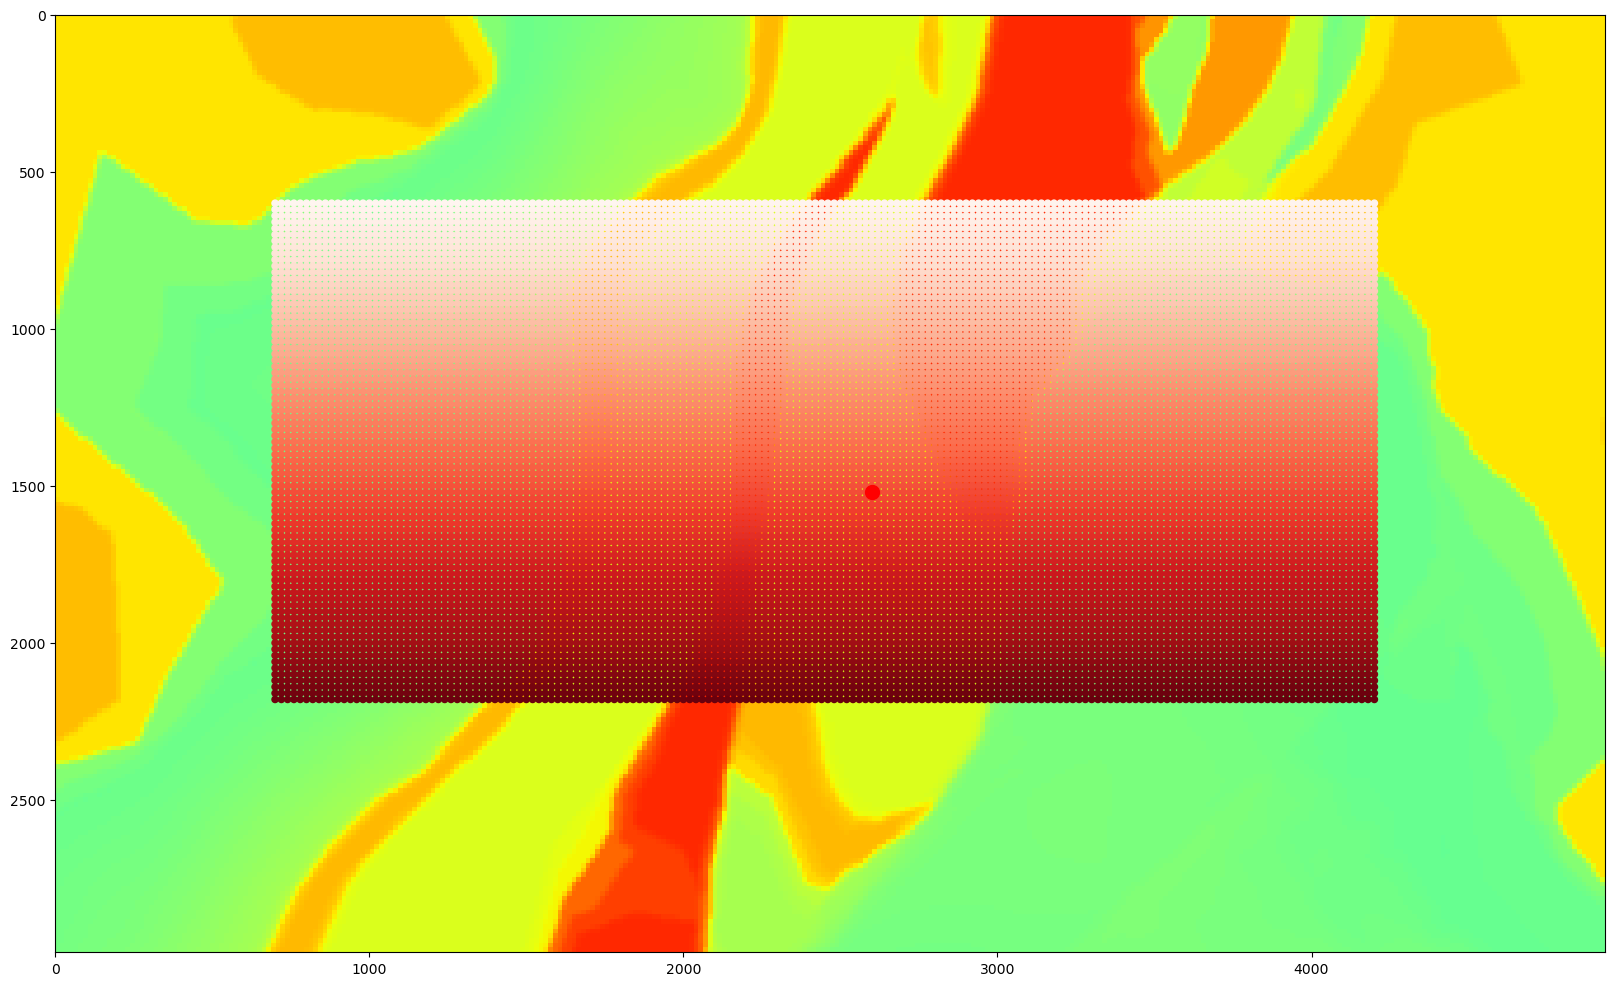

In [4]:
# Model
file = '/home/ravasim/Data/Overtrust3D/3-D_Overthrust_Model_Disk1/3D-Velocity-Grid/overthrust_small.bin'
y, x, z = np.arange(ny)*15., np.arange(nx)*15., np.arange(nz)*15.

traces = np.fromfile(file, dtype='f')
vp = traces.reshape(ny, nx, nz).astype(np.float32) # y,x,z arrangment

# Acquisition
srcx = np.arange(300,x[-1]-300, 20)
srcy = np.arange(300,y[-1]-300, 20)

SRCY, SRCX = np.meshgrid(srcy, srcx, indexing='ij')
SRCX, SRCY = SRCX.ravel(), SRCY.ravel()

recx = np.arange(700,x[-1]-700, 20)[:nrx]
recy = np.arange(600,y[-1]-600, 20)[:nry]

RECY, RECX = np.meshgrid(recy, recx, indexing='ij')
RECX, RECY = RECX.ravel(), RECY.ravel()

plt.figure(figsize=(20, 14))
plt.imshow(vp[:, :, 100], cmap='jet', clim=[1000, 3500], extent=(x[0], x[-1], y[-1], y[0]))
plt.scatter(RECX, RECY, c=np.arange(len(RECX)), s=20, cmap='Reds')
plt.scatter(SRCX[isrc], SRCY[isrc], c='r', s=100);

In [5]:
# Subsampling locations
Nsub = int(np.round(ns*perc_subsampling))

iy = np.arange(ns)
ix = np.arange(nr)
iygrid, ixgrid = np.meshgrid(iy, ix, indexing='ij')

iyava_y = np.random.randint(2, ns-2, Nsub)
iyava = np.tile(iyava_y, (nr, 1)).ravel()
ixava = np.tile(np.arange(nr), (Nsub, 1)).T.ravel()

mask2d = np.zeros((ns, nr))
mask2d[iyava, ixava] = 1
iava2d = np.where(mask2d.ravel()==1)[0]

mask3d = np.zeros((ns, nr, nt))
mask3d[iyava, ixava, :] = 1
iava3d = np.where(mask3d.ravel()==1)[0]

iyava = iygrid.ravel()[iava2d]
ixava = ixgrid.ravel()[iava2d]
Nsub = int(len(iava3d) / nt)

# Create restriction operator
Rop = Restriction(ns*nr*nt, iava=iava3d.ravel(), dtype='float64')
dottest(Rop)
mask = Rop.H*Rop*np.ones_like(data).ravel()
mask = mask.reshape(ns, nr, nt)

# Create bilinear operator
iyava_pert = iyava + np.random.uniform(-0.5, 0.5, Nsub)
ixava_pert = ixava + np.random.uniform(-0.5, 0.5, Nsub)
ixava_pert[ixava_pert<0] = 0.
ixava_pert[ixava_pert>nr-2] = nr-2
iava3d1 = np.vstack((iyava_pert, ixava_pert))

Bop = Bilinear(cp_asarray(iava3d1),(ns, nr, nt), dtype='float64')
dottest(Bop, backend='cupy')

Bop1 = Bilinear(iava3d1,(ns, nr), dtype='float64')
BopBopH = (Bop1 @ Bop1.H).todense()

Rop, Bop

(<3320000x7040000 Restriction with dtype=float64>,
 <3320000x7040000 Bilinear with dtype=float64>)

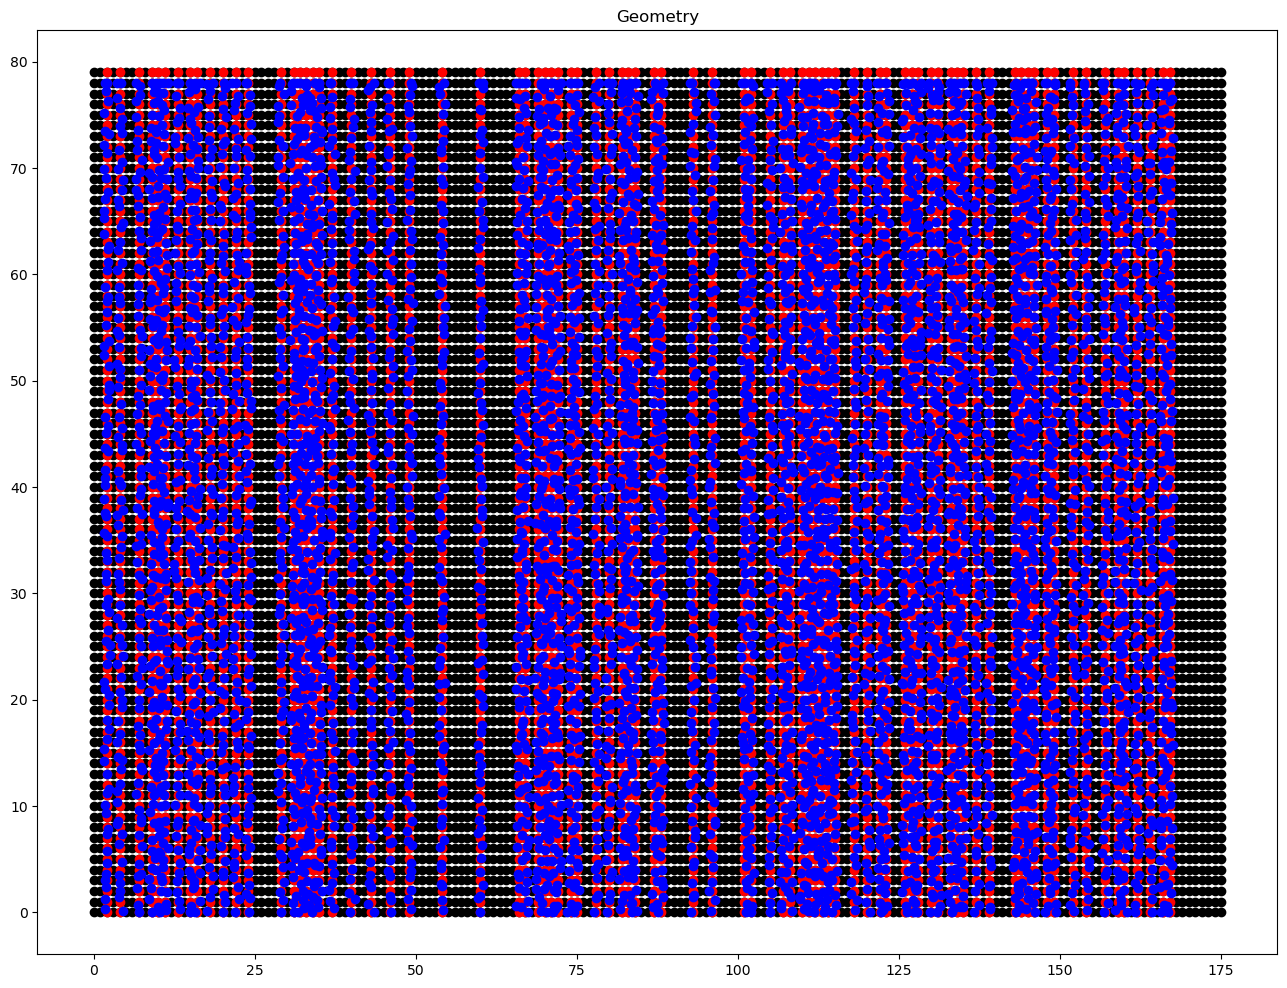

In [6]:
# Geometry 
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.scatter(iygrid, ixgrid, c='k')
ax.scatter(iyava, ixava, c='r')
ax.scatter(iava3d1[0], iava3d1[1], c='b')
ax.set_title('Geometry');

In [7]:
# Off-grid data
datasub = Bop*cp_asarray(data)
datamasked = Bop.H * datasub

datasub = cp_asnumpy(datasub)
datamasked = cp_asnumpy(datamasked)

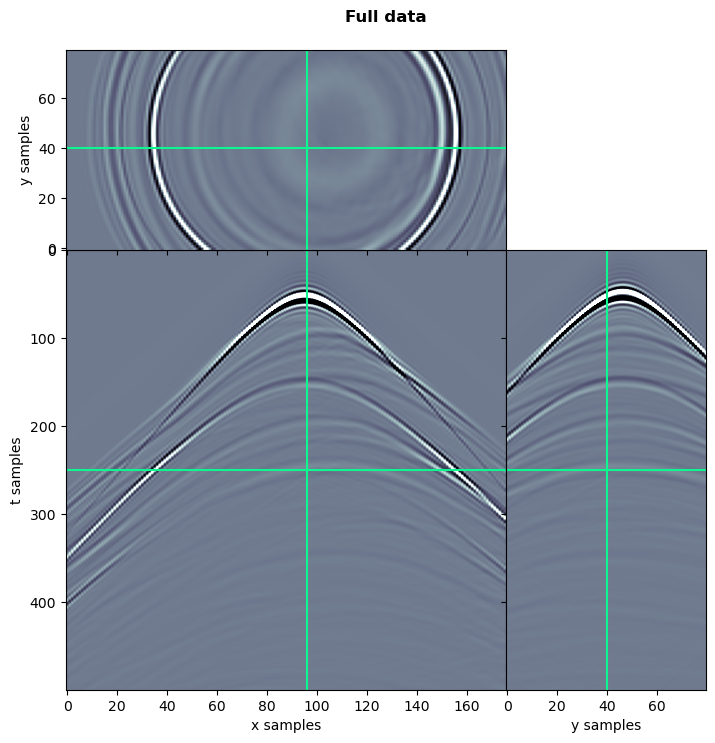

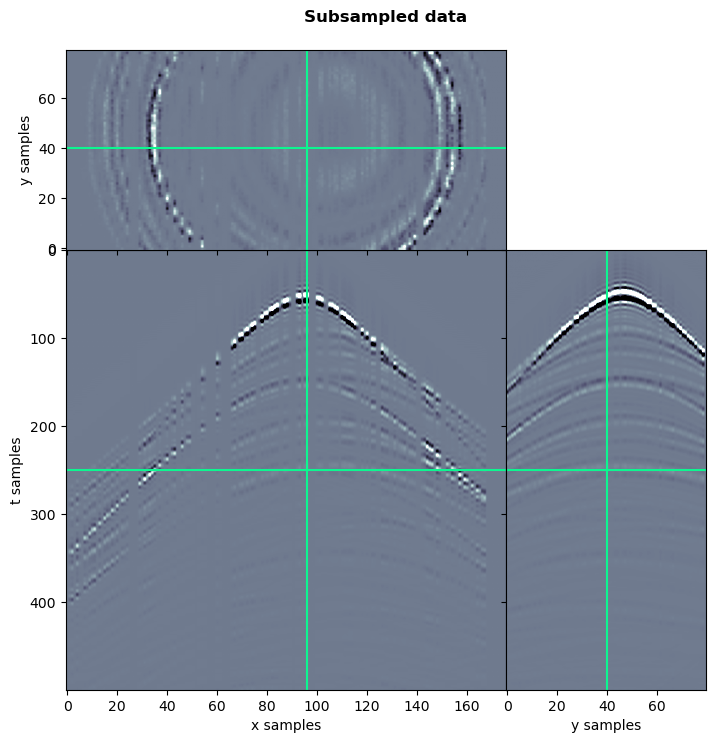

In [8]:
explode_volume(data.transpose(2, 0, 1), x=96, clipval=(-0.2,0.2), figsize=(8, 8), title='Full data')
explode_volume(datamasked.transpose(2, 0, 1), x=96, clipval=(-0.2,0.2), figsize=(8, 8), title='Subsampled data');

## Pre-processing

### Create direct arrival mask

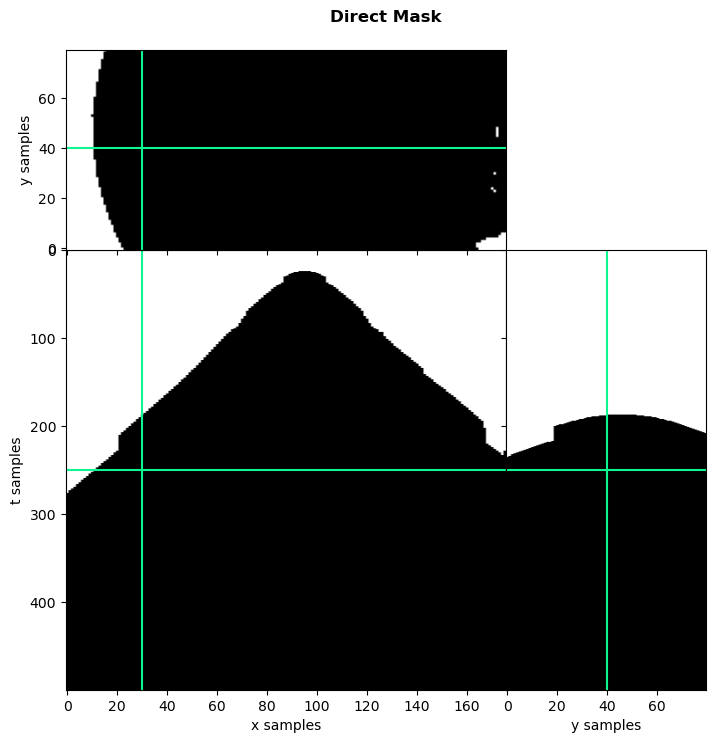

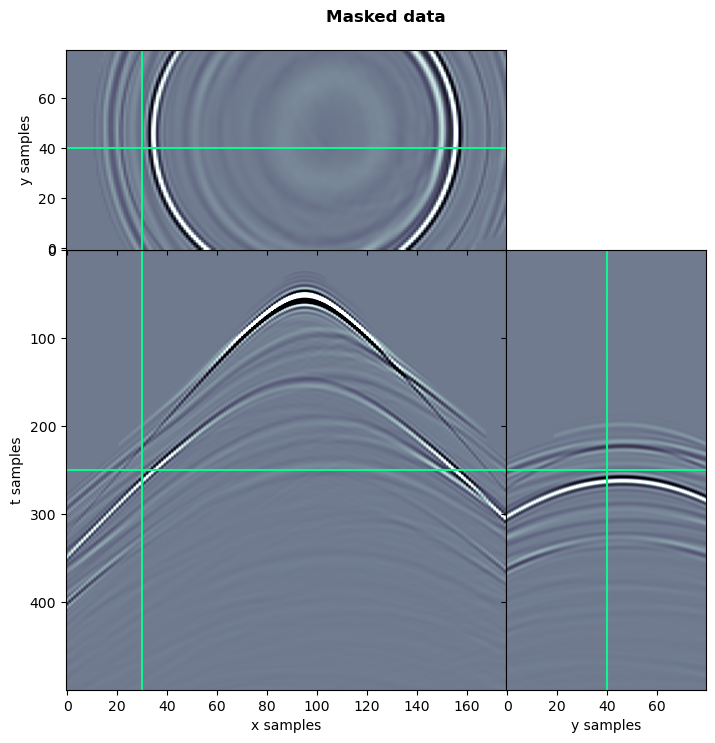

In [9]:
direct_mask = np.ones_like(data)
thresh = 0.02 * np.max(np.abs(data))
for iy in range(ns):
    for ix in range(nr):
        direct_mask[iy, ix, :max(0, np.where(np.abs(data[iy, ix]) > thresh)[0][0]-10)] = 0.

explode_volume(direct_mask.transpose(2, 0, 1), x=30, cmap='gray_r', clipval=(0, 1), figsize=(8, 8), title='Direct Mask')    
explode_volume((direct_mask*data).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Masked data');

### Divide data in patches

 468], end:[ 32  58  84 110 136 162 188 214 240 266 292 318 344 370 396 422 448 474
 500]
 576], end:[ 32  64  96 128 160 192 224 256 288 320 352 384 416 448 480 512 544 576
 608]


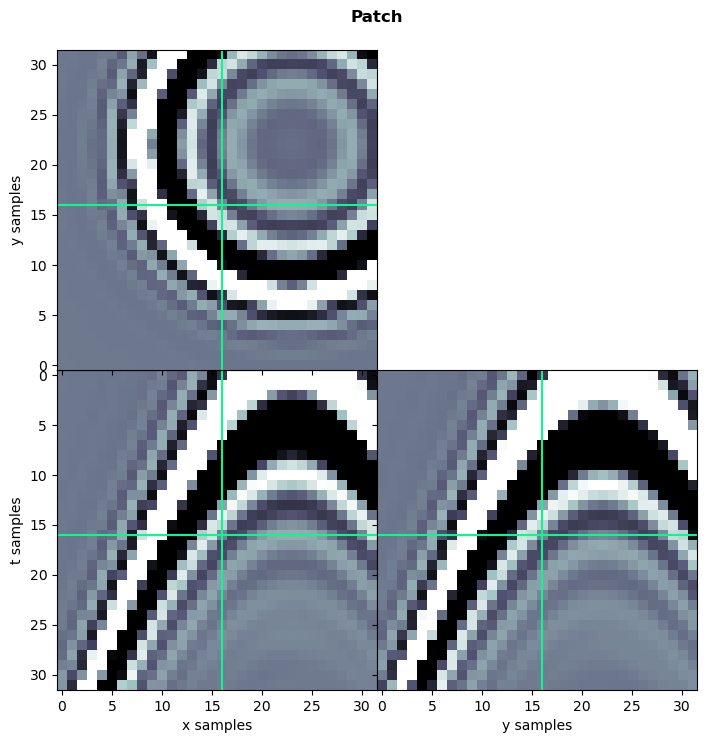

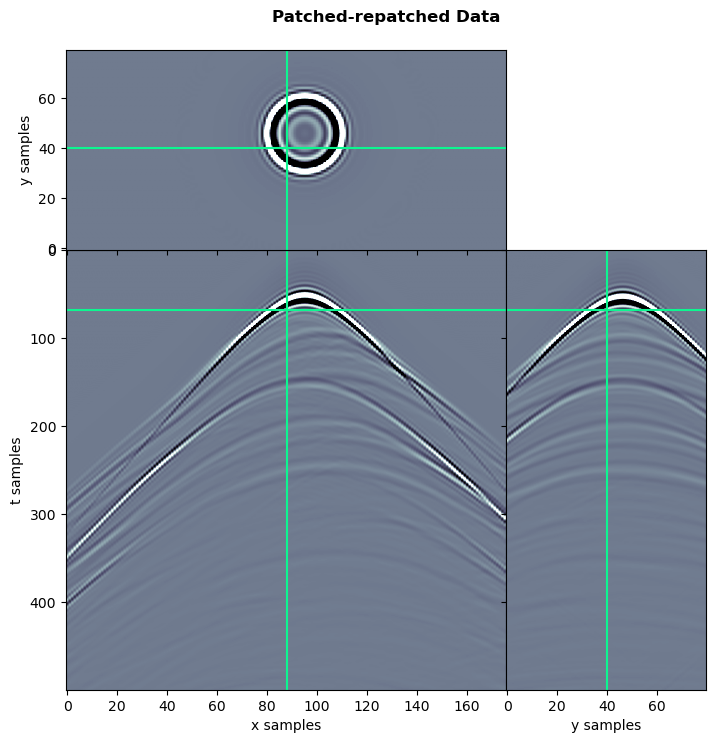

In [10]:
dimsd = data.shape
nwins, dims, mwins_inends, dwins_inends = patch3d_design(dimsd, nwin, nover, nwin)

Op = Identity(nwin[0]*nwin[1]*nwin[2], nwin[0]*nwin[1]*nwin[2])
Sop = Patch3D(Op.H, dims, dimsd, nwin, nover, nwin, tapertype=None)
Srecop = Patch3D(Op.H, dims, dimsd, nwin, nover, nwin, tapertype='cosine')
patches = Sop.H * data
patchesmasked = Sop.H * datamasked
databench = Srecop * patches

Op = Identity(nr, ns)
S1op = Sliding1D(Identity(nwin[0], nwin[0]), dims[0], dimsd[0], nwin[0], nover[0], tapertype=None)

mask_patches = Sop.H * mask

explode_volume(patches[iypatch, ixpatch, itpatch].transpose(2, 0, 1), clipval=(-0.2,0.2), figsize=(8, 8), 
               title='Patch')
explode_volume(databench.transpose(2, 0, 1), 
               t=(dwins_inends[2][0][itpatch] + dwins_inends[2][1][itpatch]) // 2,
               y=(dwins_inends[1][0][ixpatch] + dwins_inends[1][1][ixpatch]) // 2,
               x=(dwins_inends[0][0][iypatch] + dwins_inends[0][1][iypatch]) // 2,
               clipval=(-0.2,0.2), figsize=(8, 8), title='Patched-repatched Data');

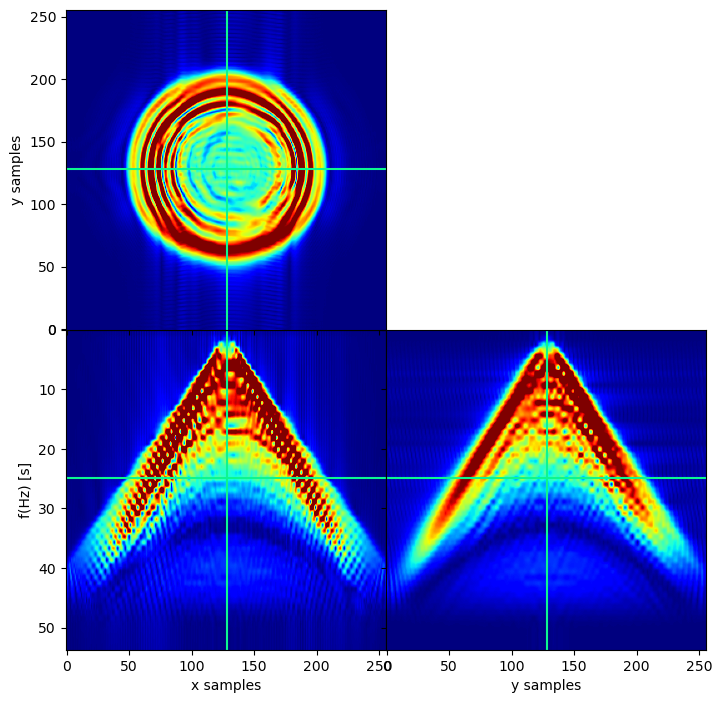

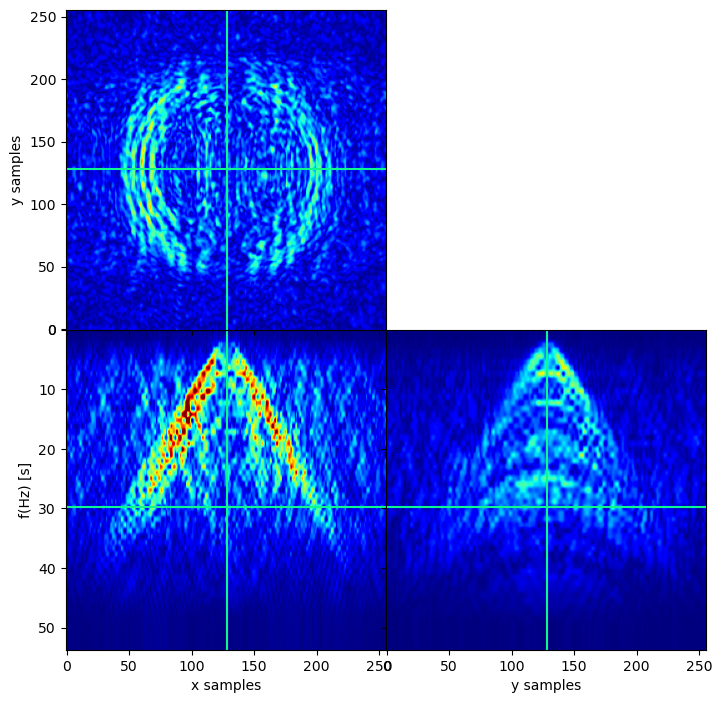

In [11]:
# FK spectra
FFTop = FFTND(dims=[ns, nr, nt], nffts=[nfft, nfft, nfft], sampling=[dx, dx, dt], real=True)

datafk = FFTop @ data
datamaskedfk = FFTop @ datamasked

explode_volume(np.fft.fftshift(np.abs(datafk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=25,
               tlim=[0,FFTop.fs[-1][55]], tlabel='f(Hz)',
               cmap='jet', figsize=(8, 8), clipval=(0,0.2))

explode_volume(np.fft.fftshift(np.abs(datamaskedfk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=30,
               tlim=[0,FFTop.fs[-1][55]], tlabel='f(Hz)',
               cmap='jet', figsize=(8, 8), clipval=(0,0.2));

### Shift data

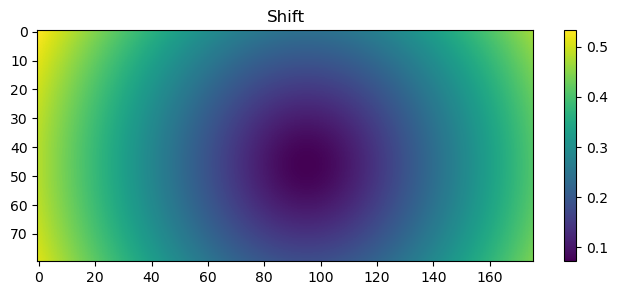

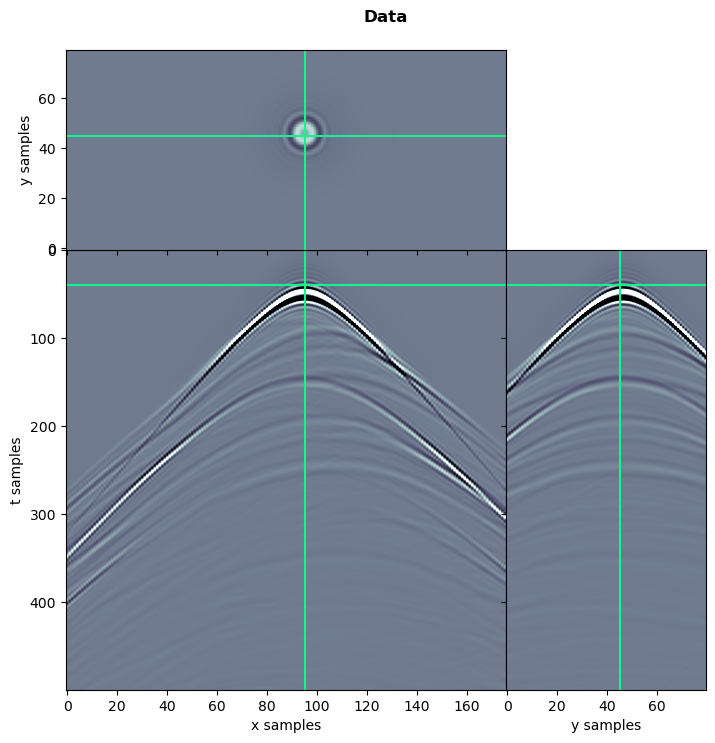

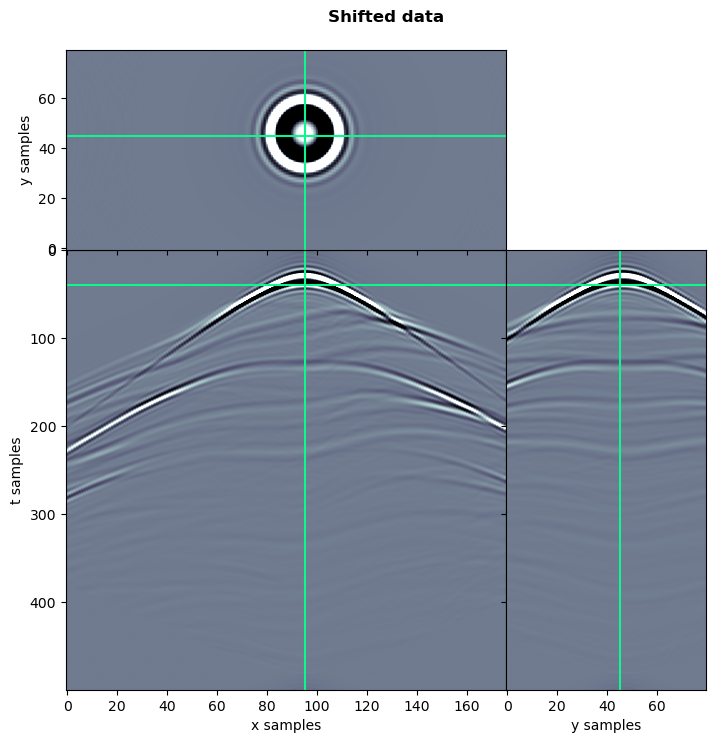

In [12]:
# Shift operator
shift = np.sqrt((300-10)**2 +
                (RECX.reshape(nry, nrx)-SRCX[isrc])**2 + 
                (RECY.reshape(nry, nrx)-SRCY[isrc])**2) / vshift

Shiftop = Shift((nrx, nry, nt), shift=-shift.T, sampling=dt, axis=2)

# Shift data
datashifted = np.real(Shiftop * data)
datareshifted = np.real(Shiftop.H * datashifted)

# Visualization
plt.figure(figsize=(8, 3))
plt.imshow(shift)
plt.axis('tight')
plt.colorbar()
plt.title('Shift')

explode_volume(data.transpose(2, 0, 1), t=40, x=95, y=45, clipval=(-0.2,0.2), figsize=(8, 8), title='Data')
explode_volume(datashifted.transpose(2, 0, 1), t=40, x=95, y=45, clipval=(-0.2,0.2), figsize=(8, 8), title='Shifted data');

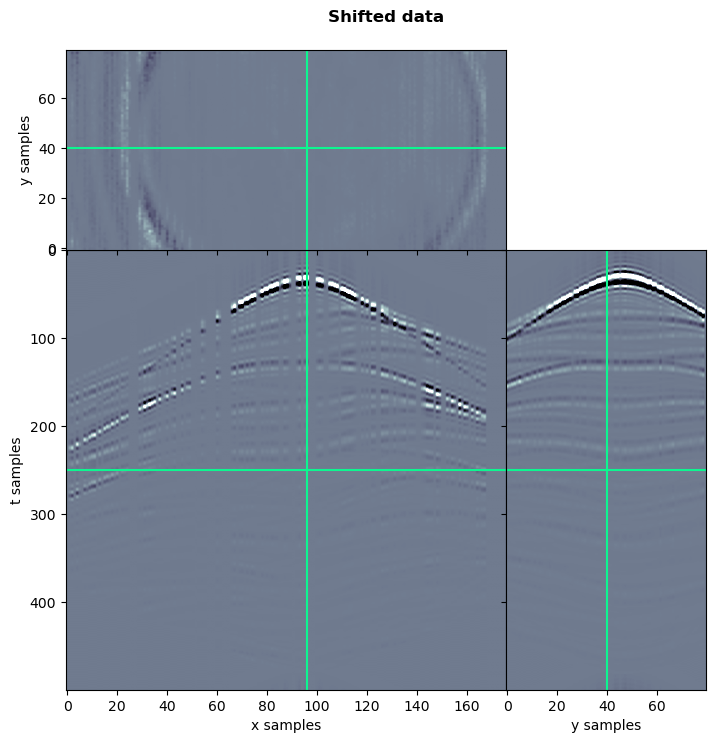

In [13]:
# Shift subsampled data
datashiftedsub = Bop*cp_asarray(datashifted)
datashiftedmasked = Bop.H * datashiftedsub

datashiftedsub = cp_asnumpy(datashiftedsub)
datashiftedmasked = cp_asnumpy(datashiftedmasked)

explode_volume(datashiftedmasked.transpose(2, 0, 1), x=96, clipval=(-0.2,0.2), figsize=(8, 8), title='Shifted data');

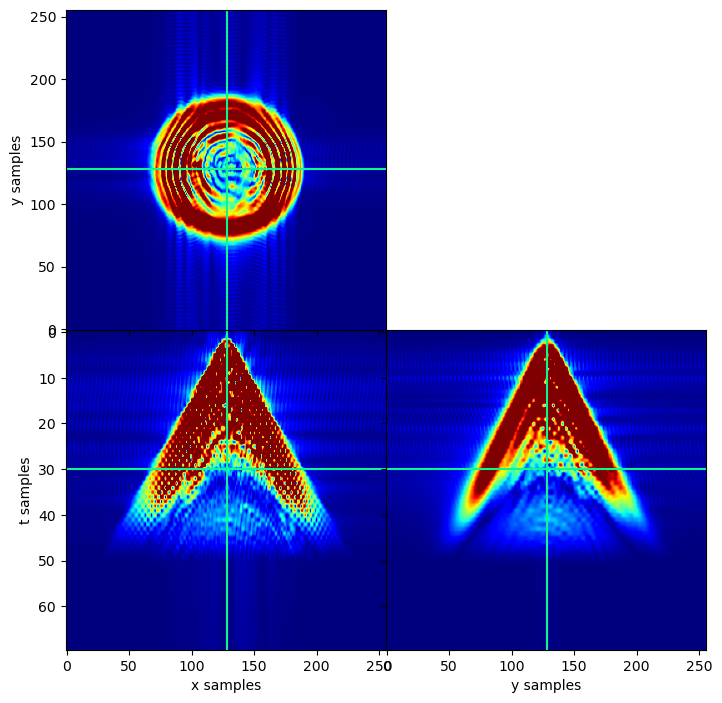

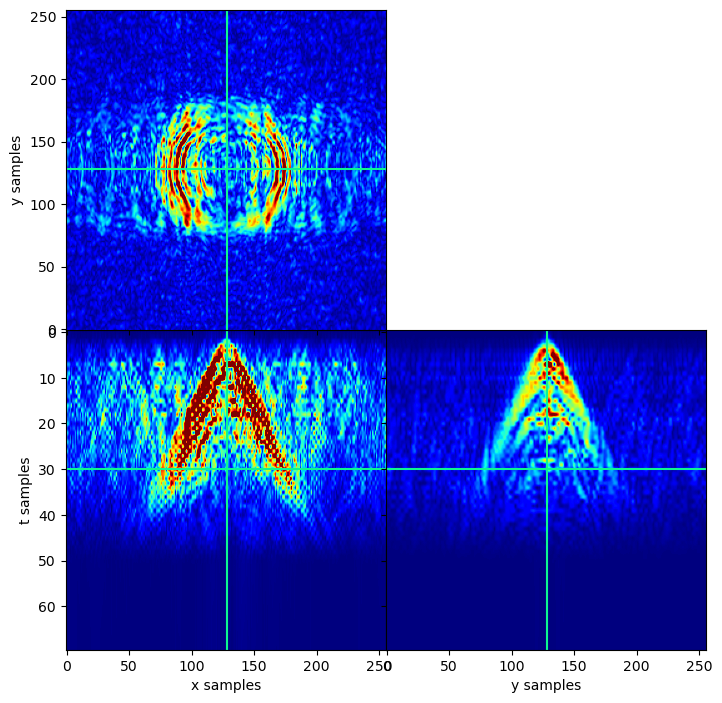

In [14]:
datashiftedfk = FFTop @ datashifted
datashiftedmaskedfk = FFTop @ datashiftedmasked

explode_volume(np.fft.fftshift(np.abs(datashiftedfk[..., :70]),axes=(0,1)).transpose(2, 0, 1), t=30,
               cmap='jet', figsize=(8, 8), clipval=(0,0.2))

explode_volume(np.fft.fftshift(np.abs(datashiftedmaskedfk[..., :70]),axes=(0,1)).transpose(2, 0, 1), t=30,
               cmap='jet', figsize=(8, 8), clipval=(0,0.2));

In [15]:
# Make patches ready for interpolation on shifted data
patchesshifted = Sop.H * datashifted
patchesshiftedmasked = Sop.H * datashiftedmasked

## Run experiments

### EPOCS exponential with bilinear

In [16]:
thresh = None

patchesshiftedinterp_epocs = np.zeros_like(patches)
patchesshiftedinterp_epocs_hist = np.zeros((int(niter // jsrnsave), *patches.shape))
error_epocsshifted = np.zeros((patches.shape[0],patches.shape[1],patches.shape[2], niter))
vb = True

for iy in range(nwins[0]):
    print(f'Working with slice {iy}/{nwins[0]}')
    for ix in range(nwins[1]):
        for it in range(nwins[2]):
            if np.sum(np.abs(patchesshiftedmasked[iy, ix, it])!=0) > 0.02*nwin[0]*nwin[1]*nwin[2]:
                if verb: print(f'Working with {iy}/{ix}/{it}')
                
                # Build bilinear operator for single patch
                iindices = np.arange(iava3d1.shape[1])
                mask1 = (iyava >= dwins_inends[0][0][iy]) & (iyava < dwins_inends[0][1][iy])
                iyava_win = iyava[mask1] 
                ixava_win = ixava[mask1] 
                iyava1_win = iava3d1[0][mask1] 
                ixava1_win = iava3d1[1][mask1] 
                iindices = iindices[mask1]

                mask2 = (ixava_win >= dwins_inends[1][0][ix]) & (ixava_win < dwins_inends[1][1][ix])
                iyava_win = iyava_win[mask2] 
                iyava1_win = iyava1_win[mask2] 
                ixava1_win = ixava1_win[mask2] 
                ixava_win = ixava_win[mask2]
                iindices = iindices[mask2]

                iava3d1_win = np.vstack((iyava1_win, ixava1_win))
                iava3d1_win_local = np.vstack((iyava1_win-dwins_inends[0][0][iy], 
                                               ixava1_win-dwins_inends[1][0][ix]))
                
                Bop = Bilinear(cp_asarray(iava3d1_win_local), nwin, dtype='float64')
                
                # Build restriction operator for single patch to be used for initial guess
                mask3d_win = np.zeros(nwin)
                mask3d_win[iyava_win-dwins_inends[0][0][iy], ixava_win-dwins_inends[1][0][ix], :] = 1
                iava3d_win = np.where(mask3d_win.ravel()==1)[0]

                Rop = Restriction(np.prod(nwin), iava=iava3d_win.ravel(), dtype='float64')
                
                y = datashiftedsub[iindices, dwins_inends[2][0][it]:dwins_inends[2][1][it]]
                x0 = cp_asarray(Rop.H * y.ravel())
                
                # Reconstruct
                patchesshiftedinterp_epocs[iy, ix, it], error_epocsshifted[iy, ix, it], patch_epocs_hist = \
                   pocs_interpolate(y, np.ones(nwin),
                                    [dx, dx, dt],
                                    nfft, thresh, threshkind='exponential1',
                                    BOp=Bop, xinit=x0, niter=niter, xtrue=patchesshifted[iy, ix, it],
                                    history=jsrnsave, backend="cupy", verb=vb)
                # Save patches at selected iterations
                for iiter in range(int(niter // jsrnsave)):
                    patchesshiftedinterp_epocs_hist[iiter, iy, ix, it] = patch_epocs_hist[iiter].reshape(nwin)
                vb = False
                
            else:
                if verb: print(f'Skipping {iy}/{ix}/{it}')                

Working with slice 0/7
threshkind=exponential1
thesh=[0.10710677 0.10362387 0.10025424 0.09699417 0.09384012 0.09078863
 0.08783637 0.08498011 0.08221673 0.07954321 0.07695663 0.07445416
 0.07203306 0.06969069 0.06742449 0.06523199 0.06311077 0.06105854
 0.05907304 0.05715211 0.05529364 0.0534956  0.05175603 0.05007303
 0.04844476 0.04686943 0.04534534 0.0438708  0.04244421 0.04106401
 0.03972869 0.0384368  0.03718691 0.03597767 0.03480775 0.03367587
 0.0325808  0.03152134 0.03049633 0.02950465 0.02854522 0.02761699
 0.02671894 0.02585009 0.0250095  0.02419624 0.02340943 0.0226482
 0.02191173 0.02119921 0.02050985 0.01984291 0.01919766 0.01857339
 0.01796942 0.0173851  0.01681977 0.01627282 0.01574366 0.01523171
 0.01473641 0.01425721 0.0137936  0.01334506 0.0129111  0.01249126
 0.01208507 0.01169209 0.01131188 0.01094404 0.01058817 0.01024386
 0.00991075 0.00958847 0.00927668 0.00897502 0.00868317 0.00840081
 0.00812763 0.00786334 0.00760764 0.00736025 0.00712091 0.00688936
 0.0066653

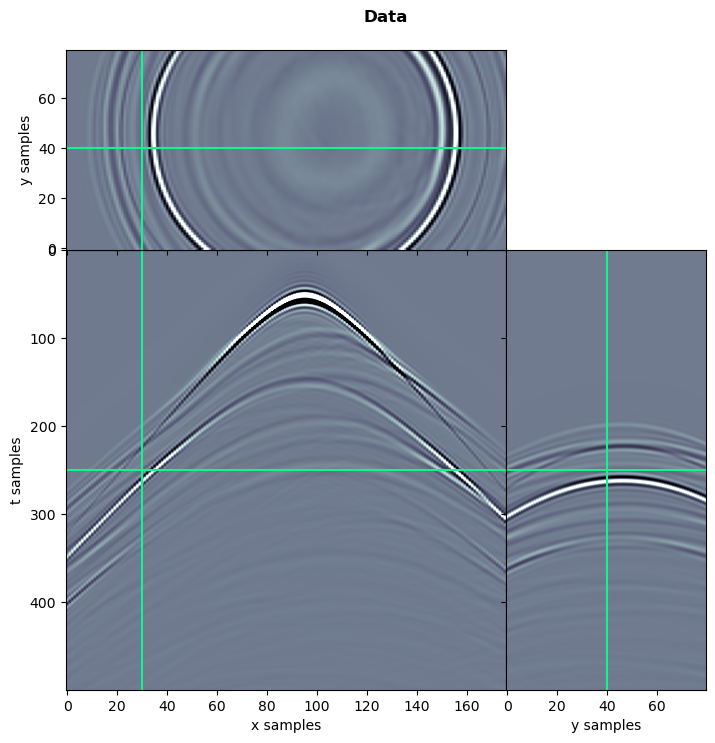

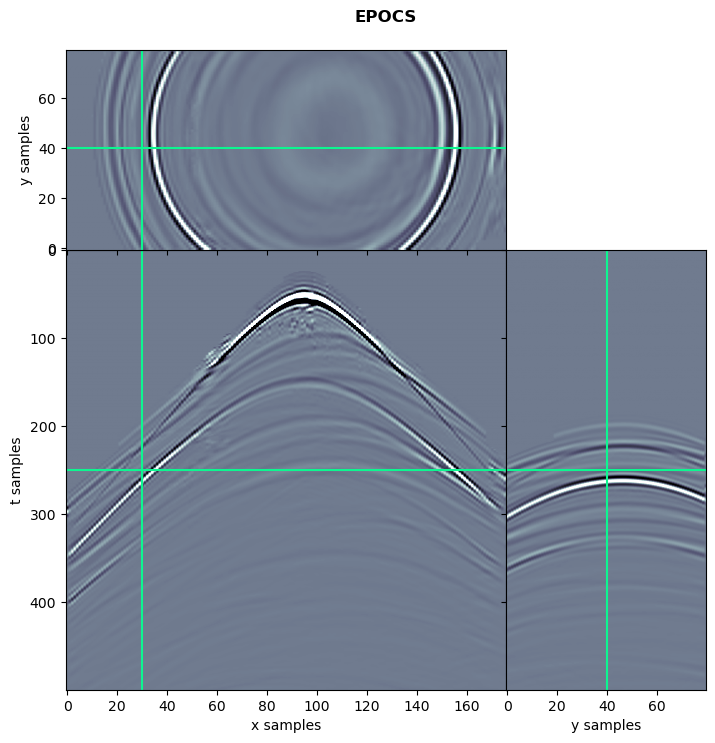

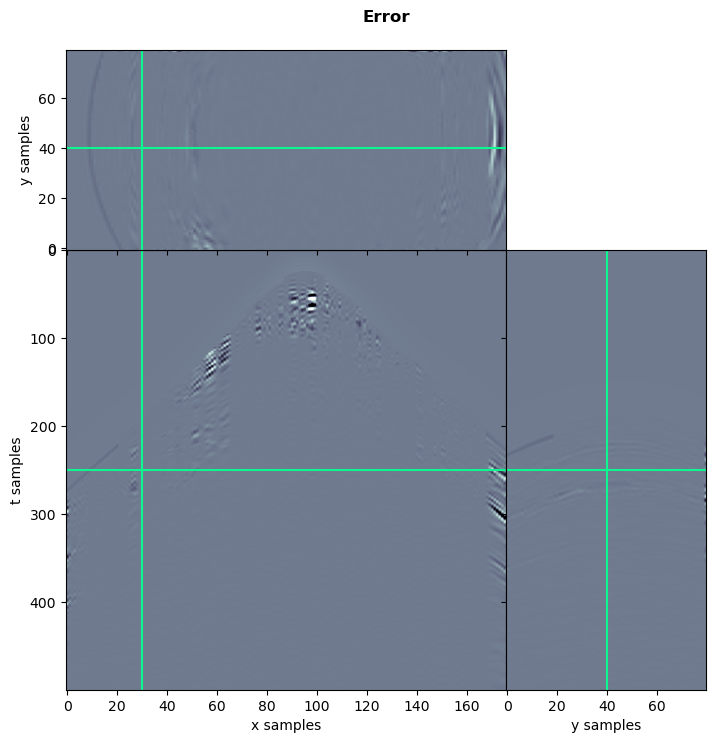

In [17]:
# Reconstruct data from patches
datarec_epocsshifted = Srecop * patchesshiftedinterp_epocs
datarec_epocsshifted[np.isnan(datarec_epocsshifted)] = 0.
datarec_epocsshiftedback = np.real(Shiftop.H * datarec_epocsshifted)

explode_volume(data.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Data')
explode_volume((direct_mask*datarec_epocsshiftedback).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), 
               figsize=(8, 8), title='EPOCS')
explode_volume((direct_mask*datarec_epocsshiftedback).transpose(2, 0, 1) - data.transpose(2, 0, 1), x=30,
               clipval=(-0.2,0.2), figsize=(8, 8), title='Error');

In [18]:
# Reconstruct intermediate data from intermediate patches and compute intermediate SNRs
snr_hist_epocs = []
for iiter in range(int(niter // jsrnsave)):
    datarec_epocsshifted_iiter = Srecop * patchesshiftedinterp_epocs_hist[iiter]
    datarec_epocsshifted_iiter[np.isnan(datarec_epocsshifted_iiter)] = 0.
    datarec_epocsshiftedback_iiter = np.real(Shiftop.H * datarec_epocsshifted_iiter)
    snr_hist_epocs.append(metrics(data, direct_mask*datarec_epocsshiftedback_iiter, itmin=0)[1])
snr_hist_epocs.append(metrics(data, direct_mask*datarec_epocsshiftedback, itmin=0)[1])
print(snr_hist_epocs)

[3.0409621320635214, 5.794224554869972, 9.349506926897465, 12.282329467306994, 13.74791965148493, 14.174062837104536, 14.2353088544357, 14.192422653783341]


In [19]:
metrics(data, direct_mask*datarec_epocsshiftedback, itmin=0, verb=True);

RMSE=0.19515463360915974, SNR=14.192422653783341


### PD exponential with bilinear (and 1 iter)

In [20]:
thresh = [.05, ]

patchesshiftedinterp_pd = np.zeros_like(patches)
patchesshiftedinterp_pd_hist = np.zeros((int(niter // jsrnsave), *patches.shape))
error_pdshifted = np.zeros((patches.shape[0],patches.shape[1],patches.shape[2], niter))
vb=True

for iy in range(nwins[0]):
    print(f'Working with slice {iy}/{nwins[0]}')
    for ix in range(nwins[1]):
        for it in range(nwins[2]):
            if np.sum(np.abs(patchesshiftedmasked[iy, ix, it])!=0) > 0.02*nwin[0]*nwin[1]*nwin[2]:
                if verb: print(f'Working with {iy}/{ix}/{it}')
                
                # Build bilinear operator for single patch
                iindices = np.arange(iava3d1.shape[1])
                mask1 = (iyava >= dwins_inends[0][0][iy]) & (iyava < dwins_inends[0][1][iy])
                iyava_win = iyava[mask1] 
                ixava_win = ixava[mask1] 
                iyava1_win = iava3d1[0][mask1] 
                ixava1_win = iava3d1[1][mask1] 
                iindices = iindices[mask1]

                mask2 = (ixava_win >= dwins_inends[1][0][ix]) & (ixava_win < dwins_inends[1][1][ix])
                iyava_win = iyava_win[mask2] 
                iyava1_win = iyava1_win[mask2] 
                ixava1_win = ixava1_win[mask2] 
                ixava_win = ixava_win[mask2] 
                iindices = iindices[mask2]

                iava3d1_win = np.vstack((iyava1_win, ixava1_win))
                iava3d1_win_local = np.vstack((iyava1_win-dwins_inends[0][0][iy], 
                                               ixava1_win-dwins_inends[1][0][ix]))
                
                Bop = Bilinear(cp_asarray(iava3d1_win_local), nwin, dtype='float64')
                
                # Build restriction operator for single patch to be used for initial guess
                mask3d_win = np.zeros(nwin)
                mask3d_win[iyava_win-dwins_inends[0][0][iy], ixava_win-dwins_inends[1][0][ix], :] = 1
                iava3d_win = np.where(mask3d_win.ravel()==1)[0]

                Rop = Restriction(np.prod(nwin), iava=iava3d_win.ravel(), dtype='float64')
                y = datashiftedsub[iindices, dwins_inends[2][0][it]:dwins_inends[2][1][it]]
                x0 = cp_asarray(Rop.H * y.ravel())
                                
                # Reconstruct
                patchesshiftedinterp_pd[iy, ix, it], error_pdshifted[iy, ix, it], patch_pd_hist = \
                   pd_interpolate(y, np.ones(nwin), [dx, dx, dt], 
                                  nfft, thresh,
                                  affine=True, identityop=False,
                                  BOp=Bop, BOpiters=1, xinit=x0, 
                                  niter=niter, xtrue=patchesshifted[iy, ix, it],
                                  history=jsrnsave, backend="cupy", verb=vb)
                # Save patches at selected iterations
                for iiter in range(int(niter // jsrnsave)):
                    patchesshiftedinterp_pd_hist[iiter, iy, ix, it] = patch_pd_hist[iiter].reshape(nwin)
                vb = False
            else:
                if verb: print(f'Skipping {iy}/{ix}/{it}')                

Working with slice 0/7
thesh=[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]
PD interpolation
f=<pyproximal.proximal.AffineSet.AffineSet object at 0x152fc9fd23a0>
g=<pyproximal.proximal.L0.L0 object at 0x152fc9fd2400>
K=<8454144x32768 _FFTND_numpy with dtype=complex128>
tau=0.99, mu=0.99
Working with slice 1/7
Working with slice 2/7
Working

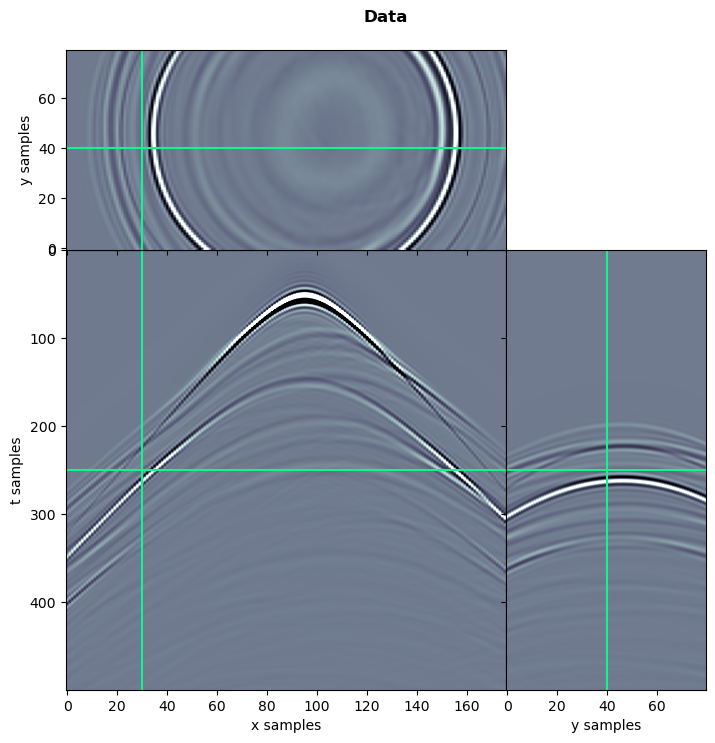

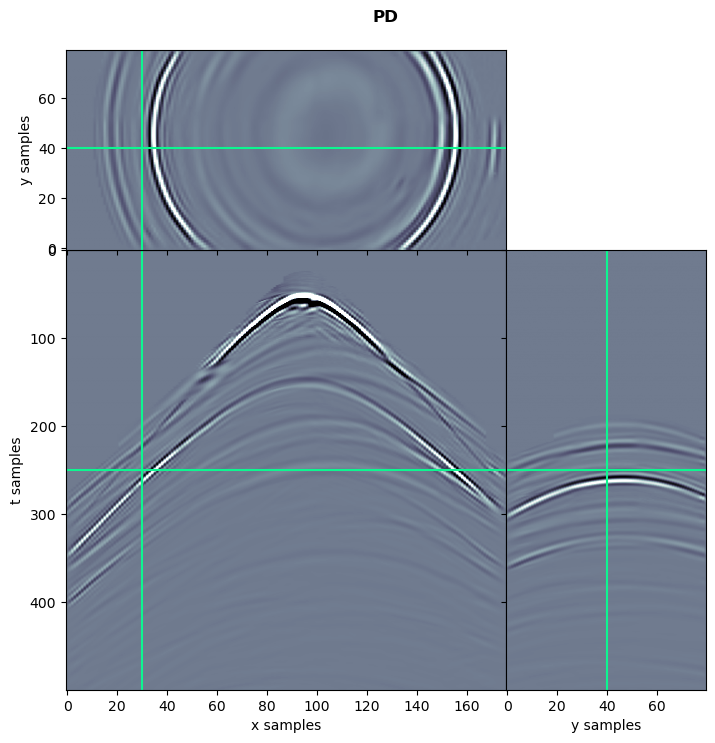

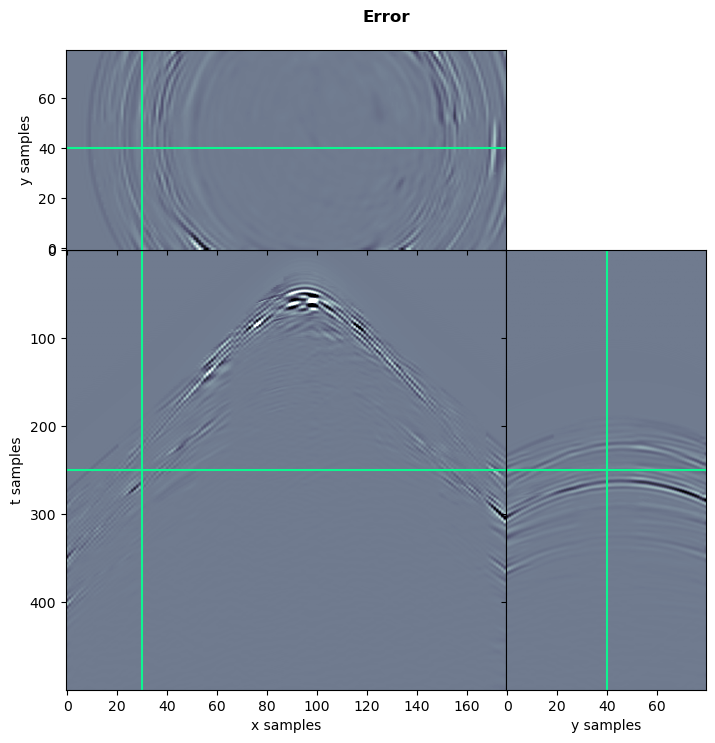

In [21]:
# Reconstruct data from patches
datarec_pdshifted = Srecop * patchesshiftedinterp_pd
datarec_pdshifted[np.isnan(datarec_pdshifted)] = 0.
datarec_pdshiftedback = np.real(Shiftop.H * datarec_pdshifted)

explode_volume(data.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Data')
explode_volume((direct_mask*datarec_pdshiftedback).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), 
               figsize=(8, 8), title='PD')
explode_volume((direct_mask*datarec_pdshiftedback).transpose(2, 0, 1) - data.transpose(2, 0, 1), x=30,
               clipval=(-0.2,0.2), figsize=(8, 8), title='Error');

In [22]:
# Reconstruct intermediate data from intermediate patches and compute intermediate SNRs
snr_hist_pd = []
for iiter in range(int(niter // jsrnsave)):
    datarec_pdshifted_iiter = Srecop * patchesshiftedinterp_pd_hist[iiter]
    datarec_pdshifted_iiter[np.isnan(datarec_pdshifted_iiter)] = 0.
    datarec_pdshiftedback_iiter = np.real(Shiftop.H * datarec_pdshifted_iiter)
    snr_hist_pd.append(metrics(data, direct_mask*datarec_pdshiftedback_iiter, itmin=0)[1])
snr_hist_pd.append(metrics(data, direct_mask*datarec_pdshiftedback, itmin=0)[1])
print(snr_hist_pd)

[3.374377294923478, 6.189521570204483, 5.436085338745391, 5.215820111226539, 5.180844100776731, 5.153898335088357, 5.1464628776677, 5.1423361109859265]


In [23]:
metrics(data, direct_mask*datarec_pdshiftedback, itmin=0, verb=True);

RMSE=0.5532013031058878, SNR=5.1423361109859265


### PD exponential with bilinear (and 2 iters)

In [24]:
thresh = [.03, ]

patchesshiftedinterp_pd1 = np.zeros_like(patches)
patchesshiftedinterp_pd1_hist = np.zeros((int(niter // jsrnsave), *patches.shape))
error_pd1shifted = np.zeros((patches.shape[0],patches.shape[1],patches.shape[2], niter))
vb=True

for iy in range(nwins[0]):
    print(f'Working with slice {iy}/{nwins[0]}')
    for ix in range(nwins[1]):
        for it in range(nwins[2]):
            if np.sum(np.abs(patchesshiftedmasked[iy, ix, it])!=0) > 0.02*nwin[0]*nwin[1]*nwin[2]:
                if verb: print(f'Working with {iy}/{ix}/{it}')
                    
                # Build bilinear operator
                iindices = np.arange(iava3d1.shape[1])
                mask1 = (iyava >= dwins_inends[0][0][iy]) & (iyava < dwins_inends[0][1][iy])
                iyava_win = iyava[mask1] 
                ixava_win = ixava[mask1] 
                iyava1_win = iava3d1[0][mask1] 
                ixava1_win = iava3d1[1][mask1] 
                iindices = iindices[mask1]

                mask2 = (ixava_win >= dwins_inends[1][0][ix]) & (ixava_win < dwins_inends[1][1][ix])
                iyava_win = iyava_win[mask2] 
                iyava1_win = iyava1_win[mask2] 
                ixava1_win = ixava1_win[mask2] 
                ixava_win = ixava_win[mask2] 
                iindices = iindices[mask2]

                iava3d1_win = np.vstack((iyava1_win, ixava1_win))
                iava3d1_win_local = np.vstack((iyava1_win-dwins_inends[0][0][iy], 
                                               ixava1_win-dwins_inends[1][0][ix]))
                
                Bop = Bilinear(cp_asarray(iava3d1_win_local), nwin, dtype='float64')
                
                # Build restriction operator
                mask3d_win = np.zeros(nwin)
                mask3d_win[iyava_win-dwins_inends[0][0][iy], ixava_win-dwins_inends[1][0][ix], :] = 1
                iava3d_win = np.where(mask3d_win.ravel()==1)[0]

                Rop = Restriction(np.prod(nwin), iava=iava3d_win.ravel(), dtype='float64')
                
                y = datashiftedsub[iindices, dwins_inends[2][0][it]:dwins_inends[2][1][it]]
                x0 = cp_asarray(Rop.H * y.ravel())
                
                # Reconstuct
                patchesshiftedinterp_pd1[iy, ix, it], error_pd1shifted[iy, ix, it], patch_pd1_hist = \
                   pd_interpolate(y, np.ones(nwin), [dx, dx, dt], 
                                  nfft, thresh,
                                  affine=True, identityop=False,
                                  BOp=Bop, BOpiters=2, xinit=x0, 
                                  niter=niter, xtrue=patchesshifted[iy, ix, it],
                                  history=jsrnsave, backend="cupy", verb=vb)
                # Save patches at selected iterations
                for iiter in range(int(niter // jsrnsave)):
                    patchesshiftedinterp_pd1_hist[iiter, iy, ix, it] = patch_pd1_hist[iiter].reshape(nwin)
                vb = False
            else:
                if verb: print(f'Skipping {iy}/{ix}/{it}')                

Working with slice 0/7
thesh=[0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
PD interpolation
f=<pyproximal.proximal.AffineSet.AffineSet object at 0x152fca31cf10>
g=<pyproximal.proximal.L0.L0 object at 0x152fc9b298e0>
K=<8454144x32768 _FFTND_numpy with dtype=complex128>
tau=0.99, mu=0.99
Working with slice 1/7
Working with slice 2/7
Working

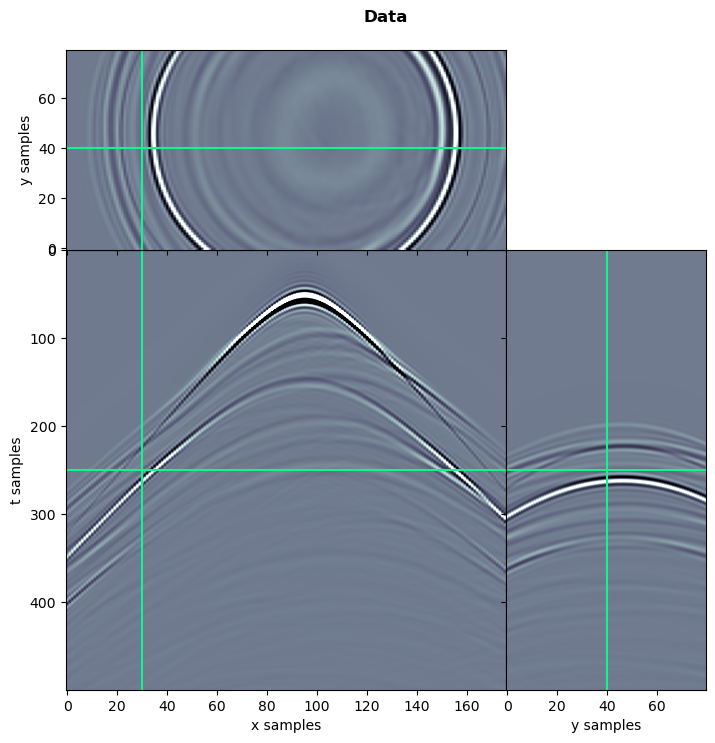

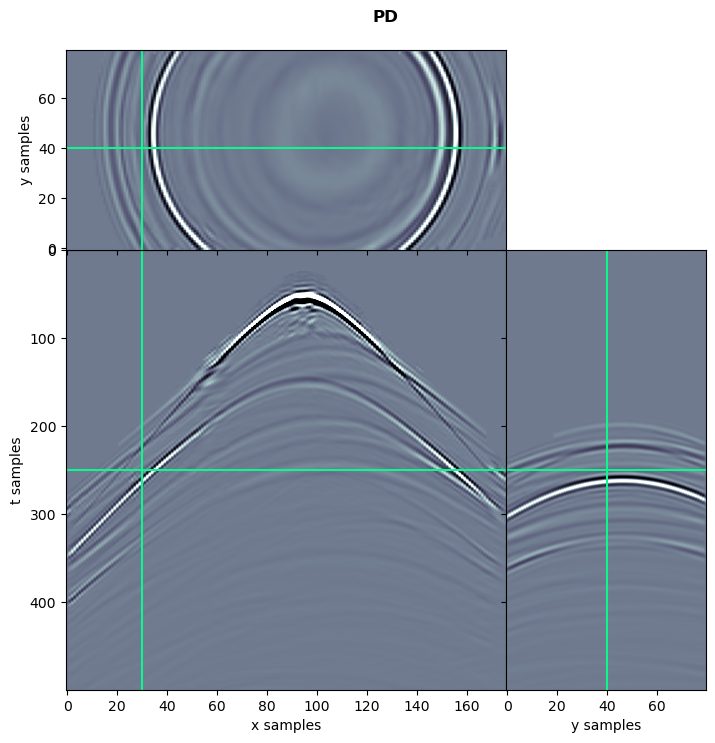

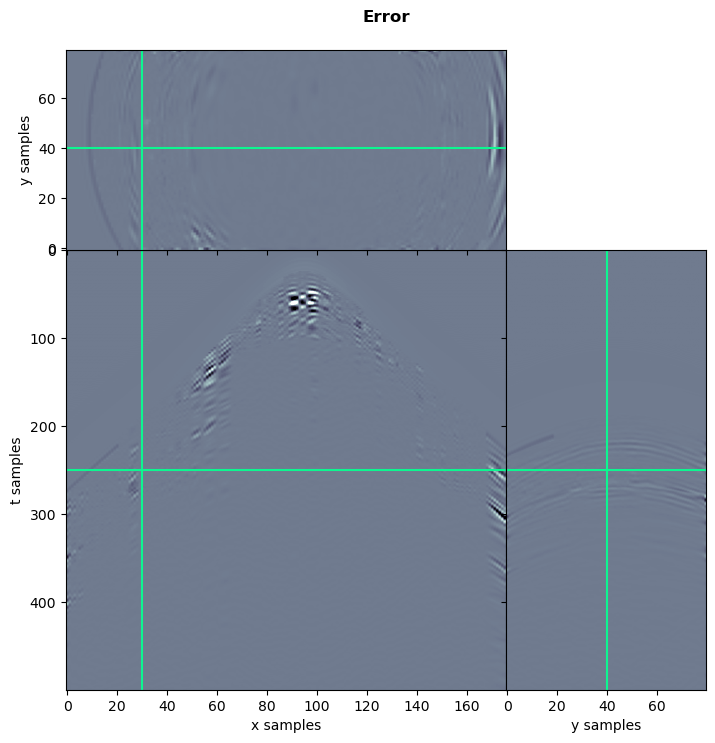

In [25]:
# Reconstruct data from patches
datarec_pd1shifted = Srecop * patchesshiftedinterp_pd1
datarec_pd1shifted[np.isnan(datarec_pd1shifted)] = 0.
datarec_pd1shiftedback = np.real(Shiftop.H * datarec_pd1shifted)

explode_volume(data.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Data')
explode_volume((direct_mask*datarec_pd1shiftedback).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), 
               figsize=(8, 8), title='PD')
explode_volume((direct_mask*datarec_pd1shiftedback).transpose(2, 0, 1) - data.transpose(2, 0, 1), x=30,
               clipval=(-0.2,0.2), figsize=(8, 8), title='Error');

In [26]:
# Reconstruct intermediate data from intermediate patches and compute intermediate SNRs
snr_hist_pd1 = []
for iiter in range(int(niter // jsrnsave)):
    datarec_pd1shifted_iiter = Srecop * patchesshiftedinterp_pd1_hist[iiter]
    datarec_pd1shifted_iiter[np.isnan(datarec_pd1shifted_iiter)] = 0.
    datarec_pd1shiftedback_iiter = np.real(Shiftop.H * datarec_pd1shifted_iiter)
    snr_hist_pd1.append(metrics(data, direct_mask*datarec_pd1shiftedback_iiter, itmin=0)[1])
snr_hist_pd1.append(metrics(data, direct_mask*datarec_pd1shiftedback, itmin=0)[1])
print(snr_hist_pd1)

[3.6882128127830938, 10.95877133121973, 12.553541290061235, 12.895784988760415, 13.016324738747961, 13.094186595651342, 13.13587834636773, 13.13871866778727]


In [27]:
metrics(data, direct_mask*datarec_pd1shiftedback, itmin=0, verb=True);

RMSE=0.22032514601425873, SNR=13.13871866778727


In [32]:
# Save results
np.savez(f'../../experiments/Overthrust/Rec_offgrid{perc_subsampling}_wins.npz', 
         datarec_epocs=datarec_epocsshiftedback,
         datarec_pdinv=datarec_pdshiftedback,
         snr_epocs=snr_hist_epocs,
         snr_pd=snr_hist_pd,
         snr_pdinv=snr_hist_pd1)

## Visualization

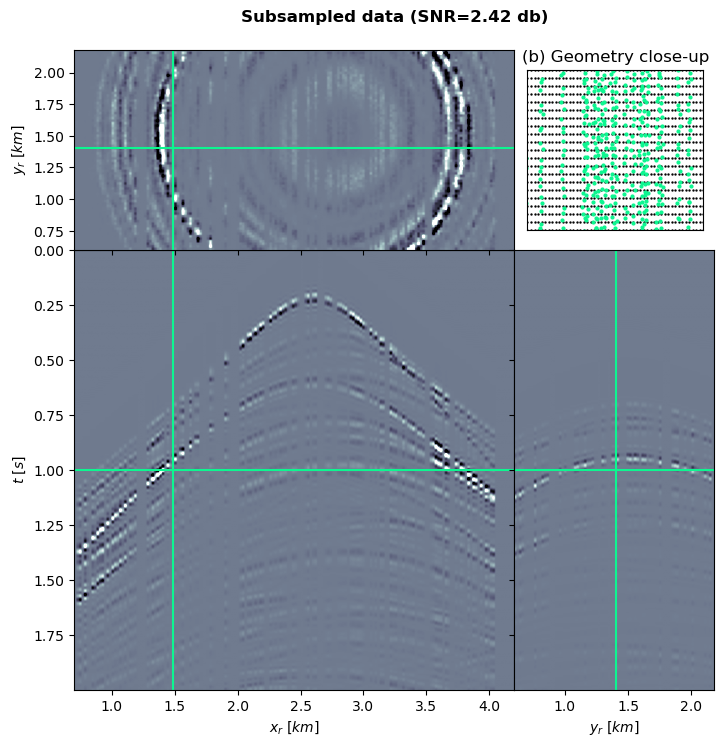

In [37]:
# Time gain
gain = t**1.5
gain = gain[:, np.newaxis, np.newaxis]
xplot = 39

_, snr = metrics(data, direct_mask*datamasked, itmin=0)
fig, axs = explode_volume(datamasked.transpose(2, 0, 1) * gain, x=xplot, 
                       tlim=[0, t[-1]], tlabel=r'$t$',
                       xlim=[recx[0]/1e3, recx[-1]/1e3], xlabel=r'$x_r$',
                       ylim=[recy[0]/1e3, recy[-1]/1e3], ylabel=r'$y_r$',
                       labels= (r'$[s]$', r'$[km]$', r'$[km]$'),
                       clipval=(-0.1,0.1), figsize=(8, 8), title=f'Subsampled data (SNR={snr:.2f} db)')

axins = axs[2].inset_axes([1.03, 0.1, 0.4, 0.8])
axins.set_xlim([50,100])
axins.set_ylim([50,30])
axins.set_xticks([])
axins.set_yticks([])

axins.scatter(iygrid, ixgrid, c='k', s=0.5)
axins.scatter(iava3d1[0], iava3d1[1], c='#0DF690', s=4)
axins.set_title('(b) Geometry close-up')
plt.savefig(f'../../figs/Overthrust/Offgrid_data.png');

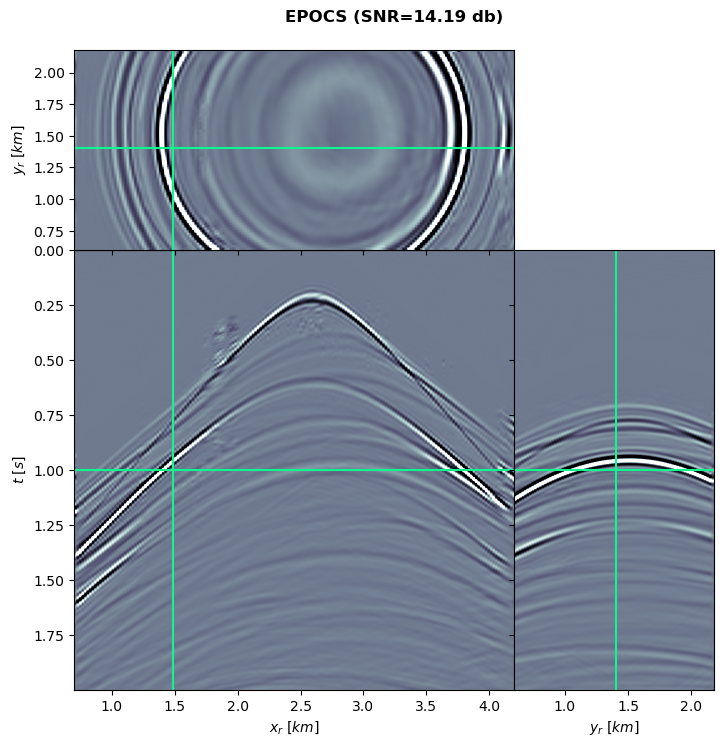

In [35]:
_, snr = metrics(data, direct_mask*datarec_epocsshiftedback, itmin=0)
fig, axs = explode_volume(datarec_epocsshiftedback.transpose(2, 0, 1) * gain, x=xplot, 
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[recx[0]/1e3, recx[-1]/1e3], xlabel=r'$x_r$',
               ylim=[recy[0]/1e3, recy[-1]/1e3], ylabel=r'$y_r$',
               labels= (r'$[s]$', r'$[km]$', r'$[km]$'),
               clipval=(-0.1,0.1), figsize=(8, 8), title=f'EPOCS (SNR={snr:.2f} db)')
plt.savefig(f'../../figs/Overthrust/Offgrid_EPOCSdata.eps');

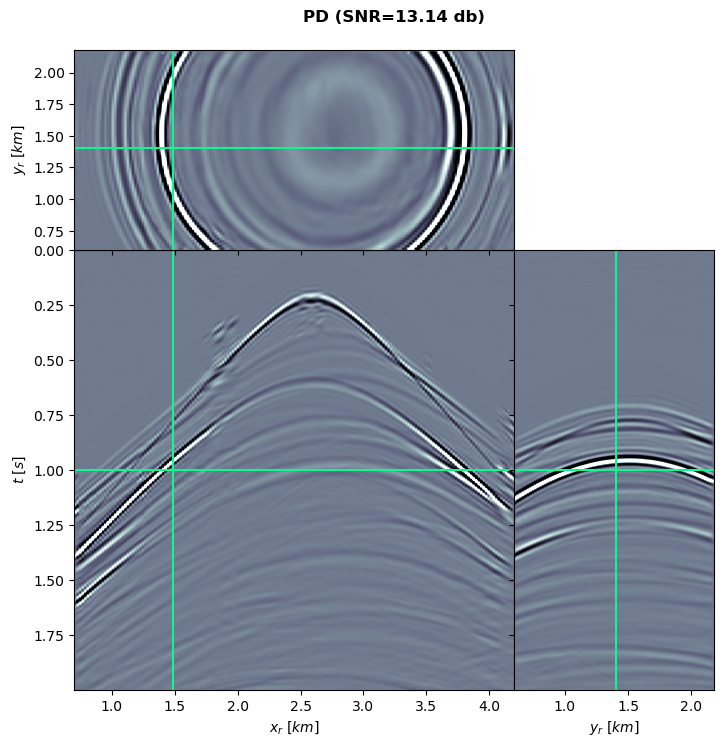

In [38]:
_, snr = metrics(data, direct_mask*datarec_pd1shiftedback, itmin=0)
fig, axs = explode_volume(datarec_pd1shiftedback.transpose(2, 0, 1) * gain, x=xplot, 
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[recx[0]/1e3, recx[-1]/1e3], xlabel=r'$x_r$',
               ylim=[recy[0]/1e3, recy[-1]/1e3], ylabel=r'$y_r$',
               labels= (r'$[s]$', r'$[km]$', r'$[km]$'),
               clipval=(-0.1,0.1), figsize=(8, 8), title=f'PD (SNR={snr:.2f} db)')
plt.savefig(f'../../figs/Overthrust/Offgrid_PDdata.png');